In [9]:
"""
Full script: Stock Price Prediction with LSTM (uses yfinance)
Save as: stock_lstm.py and run with python stock_lstm.py
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



/tmp/ipython-input-519346895.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Head of raw data:
Price           Close       High        Low       Open     Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG
Date                                                             
2010-01-04  15.504141  15.572415  15.442050  15.509088   78541293
2010-01-05  15.435865  15.531104  15.375258  15.514777  120638494
2010-01-06  15.046745  15.482122  14.999745  15.482122  159744526
2010-01-07  14.696465  15.089790  14.660596  15.074947  257533695
2010-01-08  14.892385  14.922812  14.573026  14.644517  189680313



/tmp/ipython-input-519346895.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')


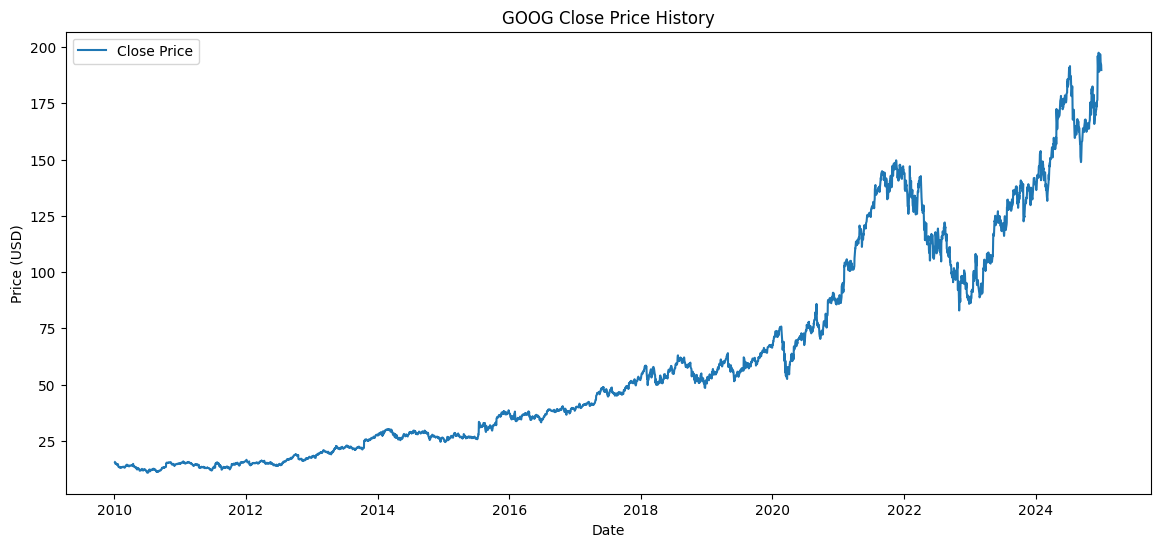

X_train shape: (2959, 60, 1), y_train shape: (2959,)
X_test shape:  (755, 60, 1),  y_test shape:  (755,)


In [12]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# -------------------------
# Parameters
# -------------------------
TICKER = 'GOOG'                   # change ticker symbol as needed
START_DATE = '2010-01-01'
END_DATE = '2025-01-01'
SEQUENCE_LENGTH = 60              # number of past days used for prediction
TEST_SPLIT = 0.2                  # fraction reserved for testing
BATCH_SIZE = 32
EPOCHS = 30
MODEL_SAVE_PATH = 'lstm_stock_model.h5'
SCALER_SAVE_PATH = 'scaler.npy'   # will store scaler.min_ and scaler.scale_

# -------------------------
# 1) Fetch data
# -------------------------
print(f"Downloading {TICKER} data from {START_DATE} to {END_DATE} ...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
if df.empty:
    raise RuntimeError("No data downloaded. Check ticker symbol or date range.")

print("Head of raw data:")
print(df.head())

# -------------------------
# 2) Preprocess
# -------------------------
# Keep only 'Close' column and ensure numeric
# Access 'Close' using the MultiIndex
df = df[('Close', TICKER)].to_frame()
df.columns = ['Close'] # Rename the column back to 'Close'
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')


# Fill missing values forward then backward (if any)
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')

# Plot closing price history
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title(f'{TICKER} Close Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Convert to numpy array
data = df.values  # shape (n_samples, 1)

# Scale data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split into training and testing datasets
train_size = int(len(scaled_data) * (1 - TEST_SPLIT))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQUENCE_LENGTH:]  # include overlap for sequences

# Helper to create sequences
def create_sequences(dataset, seq_length=SEQUENCE_LENGTH):
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i - seq_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

# reshape to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")

/tmp/ipython-input-3349653203.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')


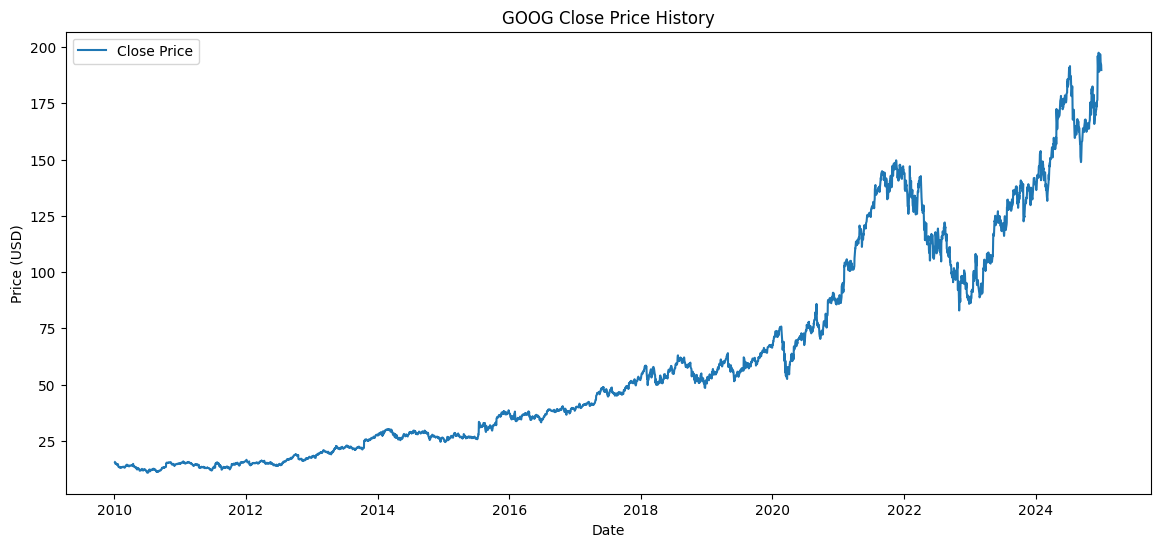

X_train shape: (2959, 60, 1), y_train shape: (2959,)
X_test shape:  (755, 60, 1),  y_test shape:  (755,)


In [13]:
df = df[['Close']].copy()
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Fill missing values forward then backward (if any)
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')

# Plot closing price history
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title(f'{TICKER} Close Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Convert to numpy array
data = df.values  # shape (n_samples, 1)

# Scale data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split into training and testing datasets
train_size = int(len(scaled_data) * (1 - TEST_SPLIT))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQUENCE_LENGTH:]  # include overlap for sequences

# Helper to create sequences
def create_sequences(dataset, seq_length=SEQUENCE_LENGTH):
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i - seq_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH)
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH)

# reshape to [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")

In [14]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_lstm_model((X_train.shape[1], 1))
model.summary()

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
ckpt = ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss', verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0104
Epoch 1: val_loss improved from inf to 0.00153, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0103 - val_loss: 0.0015
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1306e-04 
Epoch 2: val_loss improved from 0.00153 to 0.00105, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1231e-04 - val_loss: 0.0010
Epoch 3/30
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2622e-04
Epoch 3: val_loss did not improve from 0.00105
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2295e-04 - val_loss: 0.0026
Epoch 4/30
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2029e-04
Epoch 4: val_loss did not improve from 0.00105
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2069e-04 - val_loss: 0.0013
Epoch 5/30
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4664e-04
Epoch 5: val_loss improved from 0.00105 to 0.00102, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4429e-04 - val_loss: 0.0010
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5648e-04
Epoch 6: val_loss did not improve from 0.00102
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.5602e-04 - val_loss: 0.0020
Epoch 7/30
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9470e-04
Epoch 7: val_loss did not improve from 0.00102
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9328e-04 - val_loss: 0.0010
Epoch 8/30
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0616e-04
Epoch 8: val_loss did not improve from 0.00102
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0602e-04 - val_loss: 0.0011
Epoch 9/30
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1905e-04
Epoch 9: val_loss improved from 0.00102 to 0.00085, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1762e-04 - val_loss: 8.4642e-04
Epoch 10/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7800e-04
Epoch 10: val_loss did not improve from 0.00085
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7830e-04 - val_loss: 0.0026
Epoch 11/30
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8767e-04
Epoch 11: val_loss improved from 0.00085 to 0.00082, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8431e-04 - val_loss: 8.1519e-04
Epoch 12/30
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3514e-04
Epoch 12: val_loss did not improve from 0.00082
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3341e-04 - val_loss: 0.0010
Epoch 13/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3647e-04
Epoch 13: val_loss did not improve from 0.00082
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3663e-04 - val_loss: 0.0016
Epoch 14/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6800e-04
Epoch 14: val_loss did not improve from 0.00082
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6588e-04 - val_loss: 0.0017
Epoch 15/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9355e-04
Epoch 15: val_loss did not improve from 0.00082
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9301e-04 - val_loss: 9.4169e-04
Epoch 16/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2206e-04
Epoch 16: val_loss did not improve from 0.00082
93/93 ━━━━━━━

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0061e-04 - val_loss: 6.9678e-04
Epoch 18/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9316e-04
Epoch 18: val_loss did not improve from 0.00070
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9290e-04 - val_loss: 0.0011
Epoch 19/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2083e-04
Epoch 19: val_loss improved from 0.00070 to 0.00068, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2050e-04 - val_loss: 6.7910e-04
Epoch 20/30
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9773e-04
Epoch 20: val_loss improved from 0.00068 to 0.00066, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9790e-04 - val_loss: 6.6412e-04
Epoch 21/30
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6910e-04
Epoch 21: val_loss did not improve from 0.00066
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6900e-04 - val_loss: 0.0013
Epoch 22/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6567e-04
Epoch 22: val_loss did not improve from 0.00066
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6364e-04 - val_loss: 8.1435e-04
Epoch 23/30
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8844e-04
Epoch 23: val_loss improved from 0.00066 to 0.00061, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8806e-04 - val_loss: 6.1337e-04
Epoch 24/30
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6164e-04
Epoch 24: val_loss did not improve from 0.00061
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6105e-04 - val_loss: 0.0018
Epoch 25/30
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8953e-04
Epoch 25: val_loss did not improve from 0.00061
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8655e-04 - val_loss: 6.6711e-04
Epoch 26/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0155e-04
Epoch 26: val_loss improved from 0.00061 to 0.00058, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0145e-04 - val_loss: 5.8465e-04
Epoch 27/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9521e-04
Epoch 27: val_loss did not improve from 0.00058
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9511e-04 - val_loss: 7.6425e-04
Epoch 28/30
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9916e-04
Epoch 28: val_loss did not improve from 0.00058
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9871e-04 - val_loss: 0.0023
Epoch 29/30
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3743e-04
Epoch 29: val_loss improved from 0.00058 to 0.00056, saving model to lstm_stock_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3625e-04 - val_loss: 5.6268e-04
Epoch 30/30
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8843e-04
Epoch 30: val_loss did not improve from 0.00056
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8918e-04 - val_loss: 9.0591e-04
Restoring model weights from the end of the best epoch: 29.


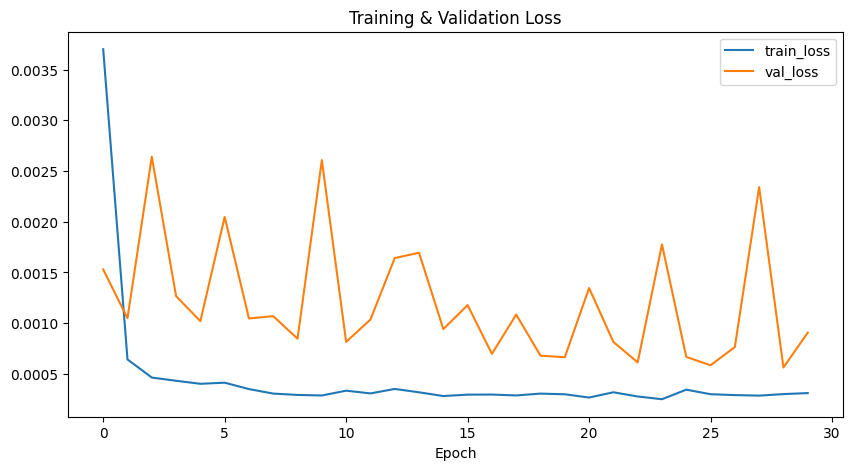

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, ckpt],
    verbose=1
)

# Plot training loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
if os.path.exists(MODEL_SAVE_PATH):
    model.load_weights(MODEL_SAVE_PATH)

predictions = model.predict(X_test)
# invert scaling
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1,1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Compute RMSE
rmse = math.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))
print(f"Test RMSE: {rmse:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Test RMSE: 4.4295


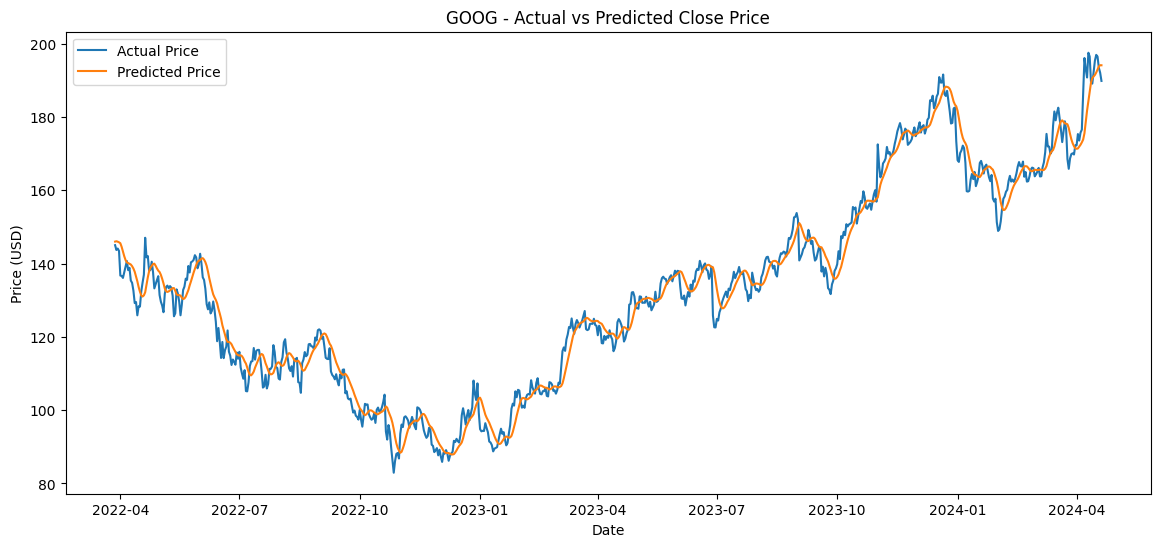

In [21]:
# Align test_dates with the length of y_test and predictions
# Get the start date of the test set predictions
test_start_date = df.index[train_size + SEQUENCE_LENGTH]
# Create a date range with the same length as the predictions/actual values
test_dates_aligned = pd.date_range(start=test_start_date, periods=len(y_test_unscaled), freq=df.index.freq)

plot_df = pd.DataFrame({
    'Date': test_dates_aligned,
    'Actual': y_test_unscaled.flatten(),
    'Predicted': predictions_unscaled.flatten()
})
plot_df = plot_df.set_index('Date')

plt.figure(figsize=(14,6))
plt.plot(plot_df['Actual'], label='Actual Price')
plt.plot(plot_df['Predicted'], label='Predicted Price')
plt.title(f'{TICKER} - Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [22]:
np.save(SCALER_SAVE_PATH, {'min_': scaler.min_, 'scale_': scaler.scale_})
print(f"Saved scaler params to {SCALER_SAVE_PATH}")


Saved scaler params to scaler.npy


In [23]:
last_seq = scaled_data[-SEQUENCE_LENGTH:]           # shape (seq_len, 1)
last_seq = last_seq.reshape((1, SEQUENCE_LENGTH, 1)) # shape (1, seq_len, 1)

next_pred_scaled = model.predict(last_seq)
next_pred = scaler.inverse_transform(next_pred_scaled.reshape(-1,1))
print(f"Next day predicted close price for {TICKER}: ${next_pred.flatten()[0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Next day predicted close price for GOOG: $193.6431


In [24]:
def predict_future_days(model, scaled_data, days=7):
    seq = scaled_data[-SEQUENCE_LENGTH:].copy()  # last window
    preds = []
    for _ in range(days):
        input_seq = seq.reshape((1, SEQUENCE_LENGTH, 1))
        pred_scaled = model.predict(input_seq)[0,0]
        preds.append(pred_scaled)
        # append and slide window
        seq = np.append(seq[1:], [[pred_scaled]], axis=0)
    preds = np.array(preds).reshape(-1,1)
    return scaler.inverse_transform(preds)

future_days = 7
future_preds = predict_future_days(model, scaled_data, days=future_days)
print(f"Next {future_days} day(s) predicted close prices:")
for i, p in enumerate(future_preds.flatten(), 1):
    print(f" Day +{i}: ${p:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Next 7 day(s) predicted close prices:
 Day +1: $193.6431
 Day +2: $193.4363
 Day +3: $193.3379
 Day +4: $193.2935
 Day +5: $193.2750
 Day +6: $193.2685
 Day +7: $193.2676
